# Intro

the dataset that will be used in this notebook is the [**Mapping 2019-nCoV**](https://systems.jhu.edu/research/public-health/ncov/) which contains several datasources (including the **WHO** and the **ECDC**) and it can be found [here](https://github.com/CSSEGISandData/COVID-19)

Particually, we will use the **CSSE COVID-19 Dataset** folder, which contains two *types* of data:

- Daily reports (csse_covid_19_daily_reports): <br>
    this folder contains daily aggregated case reports, wich contains information such the number of confirmed cases, the number of deaths, and the number of recovered cases.
    each report contains accumulated till the date of the report.
    we can use the last report to show statistic measures such as total number of cases for each country, most affected countries, etc ..., but we can perform time analysis on the data.
- Time series summary (csse_covid_19_time_series):

# Import Libraries and Read Data

In [1]:
import glob
import pandas as pd
import numpy as np

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px

import plotly.graph_objects as go
from plotly.graph_objects import Bar
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set()

/home/resaln/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
def get_last_report_date(reports_path):
    
    # this is a buggy code, that just works!
    # this function is used to get the date of the last report data in csse_covid_19_daily_reports folder
    
    files_names_list = glob.glob(f"{reports_path}/*.csv")
    
    files_names_list = sorted(files_names_list)
    
    last_report_name = files_names_list[-1].split("/")[-1]
    
    last_report_date = last_report_name.split(".")[0]
    
    return last_report_date

In [3]:
last_report_date = get_last_report_date("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports")

In [4]:
last_report_date

'06-04-2020'

In [5]:
last_report_path = f'COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/{last_report_date}.csv'
world_pop_path = 'other-data/World Population Data/total_population_clean.csv'
pop_ages_1_path = 'other-data/World Population Data/population_ages_0-14_clean.csv'
pop_ages_2_path = 'other-data/World Population Data/population_ages_15-64_clean.csv'
pop_ages_3_path = 'other-data/World Population Data/population_ages_65_clean.csv'

In [6]:
df = pd.read_csv(last_report_path)
world_pop_df = pd.read_csv(world_pop_path)
pop_ages_group_1_df = pd.read_csv(pop_ages_1_path)
pop_ages_group_2_df = pd.read_csv(pop_ages_2_path)
pop_ages_group_3_df = pd.read_csv(pop_ages_3_path)

# Helper functions

In [7]:
def save_fig_as_div(fig_obj, file_name):
    with open(f'charts/{file_name}', 'w') as fig_file:
        fig_div_string = plotly.offline.plot(figure_or_data=fig_obj, output_type='div',
                                             include_plotlyjs='cdn')
        fig_file.write(fig_div_string)

In [8]:
def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

In [9]:
def get_most_n_affected_countries(df, n):
    most_affected_countries_names = df['Country'][:n].values
    
    most_affected_df = df[df['Country'].isin(most_affected_countries_names)]
    
    return most_affected_df

In [10]:
def get_countries_fatalities(df):
    countries_fatalities_df = pd.DataFrame(data=df[['Country', 'Confirmed', 'Deaths']])

    countries_fatalities_df['Fatality rate'] = (countries_fatalities_df['Deaths'] * 100.0) / countries_fatalities_df['Confirmed']

    countries_fatalities_df = countries_fatalities_df.round({'Fatality rate': 2})

    countries_fatalities_df.sort_values(by='Confirmed', ascending=False, inplace=True)
    
    return countries_fatalities_df

# Get to know the data

In [11]:
df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,Abbeville,South Carolina,US,2020-06-05 02:33:06,34.223334,-82.461707,46,0,0,46,"Abbeville, South Carolina, US",187.548416,0.000000
1,22001.0,Acadia,Louisiana,US,2020-06-05 02:33:06,30.295065,-92.414197,462,26,0,436,"Acadia, Louisiana, US",744.620840,5.627706
2,51001.0,Accomack,Virginia,US,2020-06-05 02:33:06,37.767072,-75.632346,966,12,0,954,"Accomack, Virginia, US",2989.231341,1.242236
3,16001.0,Ada,Idaho,US,2020-06-05 02:33:06,43.452658,-116.241552,823,22,0,801,"Ada, Idaho, US",170.893317,2.673147
4,19001.0,Adair,Iowa,US,2020-06-05 02:33:06,41.330756,-94.471059,9,0,0,9,"Adair, Iowa, US",125.838926,0.000000


In [12]:
df.shape

(3645, 14)

In [13]:
len(df['Country_Region'].unique())

188

Field description
- Province/State: China - province name; US/Canada/Australia/ - city name, state/province name; Others - name of the event (e.g., "Diamond Princess" cruise ship); other countries - blank.
- Country/Region: country/region name conforming to WHO (will be updated).
- Last Update: MM/DD/YYYY HH:mm (24 hour format, in UTC).
- Confirmed: the number of confirmed cases.
- Deaths: the number of deaths.
- Recovered: the number of recovered cases.
- Active: Active cases = total confirmed - total recovered - total deaths.

## Populations Ages groups

In [14]:
pop_ages_group_1_df.head()

,Country,Country Code,percentage
0,Aruba,ABW,17.802447
1,Afghanistan,AFG,43.090176
2,Angola,AGO,46.808925
3,Albania,ALB,17.672874
4,Andorra,AND,NaN


In [15]:
pop_ages_group_2_df.head()

,Country,Country Code,percentage
0,Aruba,ABW,68.646606
1,Afghanistan,AFG,54.324898
2,Angola,AGO,50.974702
3,Albania,ALB,68.582390
4,Andorra,AND,NaN


In [16]:
pop_ages_group_3_df.head()

,Country,Country Code,percentage
0,Aruba,ABW,13.550947
1,Afghanistan,AFG,2.584927
2,Angola,AGO,2.216374
3,Albania,ALB,13.744736
4,Andorra,AND,NaN


## Countries age structure statistics:

This data contains the percentages of age groups of population in each country, the age groups are:

- Ages 0 to 14 years: children and adolescents.
- Ages 15 to 64 years: working population or population in education
- Over the age of 65: retirees; elderly

will use this data later to study the relation between death rate and percentage of elderly.

In [17]:
countries_ages_groups_df = pop_ages_group_1_df.merge(pop_ages_group_2_df, left_on='Country',
                                                     right_on='Country', how='inner',
                                                     suffixes=('_group_1', '_group_2'))\
    .merge(pop_ages_group_3_df, left_on='Country', right_on='Country', how='inner')\
    .drop(columns=['Country Code_group_1', 'Country Code_group_2', 'Country Code'])\
    .rename(columns={
        'percentage_group_1': '0 to 14 years',
        'percentage_group_2': '15 to 64 years',
        'percentage': 'over 65 years'
    })

In [18]:
countries_ages_groups_df.head()

,Country,0 to 14 years,15 to 64 years,over 65 years
0,Aruba,17.802447,68.646606,13.550947
1,Afghanistan,43.090176,54.324898,2.584927
2,Angola,46.808925,50.974702,2.216374
3,Albania,17.672874,68.582390,13.744736
4,Andorra,NaN,NaN,NaN


# Data Preprocessing

In [19]:
df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,Abbeville,South Carolina,US,2020-06-05 02:33:06,34.223334,-82.461707,46,0,0,46,"Abbeville, South Carolina, US",187.548416,0.000000
1,22001.0,Acadia,Louisiana,US,2020-06-05 02:33:06,30.295065,-92.414197,462,26,0,436,"Acadia, Louisiana, US",744.620840,5.627706
2,51001.0,Accomack,Virginia,US,2020-06-05 02:33:06,37.767072,-75.632346,966,12,0,954,"Accomack, Virginia, US",2989.231341,1.242236
3,16001.0,Ada,Idaho,US,2020-06-05 02:33:06,43.452658,-116.241552,823,22,0,801,"Ada, Idaho, US",170.893317,2.673147
4,19001.0,Adair,Iowa,US,2020-06-05 02:33:06,41.330756,-94.471059,9,0,0,9,"Adair, Iowa, US",125.838926,0.000000


## 1 - Drop irrelevant columns:

`FIPS`: the **FIPS** represents the Federal Information Processing Standard state code, and it's related only to the `U.S.` states, we won't need it now (unless we want to draw a map specific to the `U.S.`)

`Admin2`: it's not clear what does this column means, will be dropped :)

`Province_State`: the city on which the case was recorded, but not all cases are associated with the city, so we will drop it.

In [20]:
df['Province_State'].isna().sum()

173

`Last_update`: the date on which this row was last updated, irrelvant to our analysis.

`Lat` and `Long_` columns specify the coordinates of the case, we won't be needing this inofrmation right now.

`Combined_Key`: this column is the concatenation of `Admin2`, `Province_State`, and ` 	Country_Region`, irrelvant too.

In [21]:
def drop_irrelevant_columns(df, irrelevant_columns):
    new_df = df.drop(columns=irrelevant_columns)
    return new_df

In [22]:
irrelevant_columns = ['FIPS', 'Admin2', 'Province_State', 'Last_Update',
                      'Lat', 'Long_', 'Combined_Key']

In [23]:
df = drop_irrelevant_columns(df, irrelevant_columns)

In [24]:
df.head()

,Country_Region,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
0,US,46,0,0,46,187.548416,0.000000
1,US,462,26,0,436,744.620840,5.627706
2,US,966,12,0,954,2989.231341,1.242236
3,US,823,22,0,801,170.893317,2.673147
4,US,9,0,0,9,125.838926,0.000000


## 2 - Normalize columns' names:

rename column `Country_Region` to `Country`, for easier manipulation

In [25]:
def rename_columns(df, columns_mapping):
    new_df = df.rename(columns=columns_mapping)
    return new_df

In [26]:
columns_mapping = {
    'Country_Region': 'Country'
}

In [27]:
df = rename_columns(df, columns_mapping)

In [28]:
df.head()

,Country,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
0,US,46,0,0,46,187.548416,0.000000
1,US,462,26,0,436,744.620840,5.627706
2,US,966,12,0,954,2989.231341,1.242236
3,US,823,22,0,801,170.893317,2.673147
4,US,9,0,0,9,125.838926,0.000000


## 3 - Aggregate data by countries:
aggregate the number of confirmed cases, number of deaths, number of reovered cases, and number of active cases for each country.

In [29]:
def apply_aggregation(df, group_by_column, sort_by_column):
    aggregate_df = df.groupby(by=group_by_column)\
                        .sum()\
                        .reset_index()\
                        .sort_values(by=sort_by_column, ascending=False)
    return aggregate_df

In [30]:
aggregated_df = apply_aggregation(df, group_by_column='Country', sort_by_column='Deaths')

In [31]:
aggregated_df.head(10)

,Country,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
174,US,1872660,108211,485002,1334501,1.047637e+06,10583.617155
178,United Kingdom,283079,39987,1219,241873,2.793186e+03,66.442107
23,Brazil,614941,34021,254963,325957,1.074224e+04,101.005937
85,Italy,234013,33689,161895,38429,7.638013e+03,225.994189
62,France,189569,29068,70094,90407,1.585106e+03,40.160393
158,Spain,240660,27133,150376,63151,8.990915e+03,189.705030
113,Mexico,105680,12545,74758,18377,2.376546e+03,372.691902
16,Belgium,58767,9548,16048,33171,5.070660e+02,16.247214
66,Germany,184472,8635,167909,7928,2.969455e+03,69.826152
81,Iran,164270,8071,127485,28714,1.955759e+02,4.913253


the number of `Confirmed` cases in each country should be equal to the sum of: `Deaths`, `Recovered`, and `Active`

In [32]:
aggregated_df['Confirmed'].eq(aggregated_df['Deaths'] + aggregated_df['Recovered'] + aggregated_df['Active']).sum()

187

In [33]:
aggregated_df.shape

(188, 7)

## 4 - Focus on *Outbreaks*:
We will focus in this notebook only on countries with high **death tolls**, countires that are *nearly* affected by the pandemic will be discarded.

In [34]:
most_n_countries = 15

In [35]:
most_affected_countries_names = aggregated_df['Country'][:most_n_countries].values

In [36]:
print(most_affected_countries_names)

['US' 'United Kingdom' 'Brazil' 'Italy' 'France' 'Spain' 'Mexico'
 'Belgium' 'Germany' 'Iran' 'Canada' 'India' 'Netherlands' 'Russia' 'Peru']


In [37]:
most_affected_df = aggregated_df[aggregated_df['Country'].isin(most_affected_countries_names)]

In [38]:
most_affected_df

,Country,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
174,US,1872660,108211,485002,1334501,1.047637e+06,10583.617155
178,United Kingdom,283079,39987,1219,241873,2.793186e+03,66.442107
23,Brazil,614941,34021,254963,325957,1.074224e+04,101.005937
85,Italy,234013,33689,161895,38429,7.638013e+03,225.994189
62,France,189569,29068,70094,90407,1.585106e+03,40.160393
158,Spain,240660,27133,150376,63151,8.990915e+03,189.705030
113,Mexico,105680,12545,74758,18377,2.376546e+03,372.691902
16,Belgium,58767,9548,16048,33171,5.070660e+02,16.247214
66,Germany,184472,8635,167909,7928,2.969455e+03,69.826152
81,Iran,164270,8071,127485,28714,1.955759e+02,4.913253


# Data Visualization

In [39]:
reds = get_n_color_palette('Reds', n_colors=most_n_countries, as_hex=True)

## Overall Statistics

In [40]:
overall_stats_df = pd.DataFrame(df[['Deaths', 'Recovered', 'Active']].sum(), columns=['total'])\
                                .reset_index()\
                                .rename(columns={
                                        'index': 'measure'
                                })

In [41]:
overall_stats_df.head()

,measure,total
0,Deaths,391136
1,Recovered,2869963
2,Active,3426940


In [42]:
fig = px.pie(data_frame=overall_stats_df, values='total', names='measure',
             color='measure', color_discrete_map={
                 'Active': 'orange',
                 'Recovered': 'green',
                 'Deaths': 'red'
             })

fig.update_layout(autosize=False,
                  width=800, height=600,
                  title_text='<i><b>Overall statistics</b></i>',
                  xaxis_title="Measures", yaxis_title="Class",
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

fig.show()

In [43]:
save_fig_as_div(fig, 'overall_stats_pie_chart.html')

## Pie Chart

In [44]:
fig = px.pie(most_affected_df, names='Country', values='Deaths',
             color='Deaths', color_discrete_sequence=reds)

fig.update_layout(autosize=False,
                  width=800, height=700,
                  title_text='<i><b>Most affected 15 countries by deaths</b></i>',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

fig.show()

In [45]:
save_fig_as_div(fig_obj=fig, file_name="most_affected_countries_pie_chart.html")

## Treemap Chart

In [46]:
country_continent_df = pd.read_csv("other-data/Countries-Continents.csv")

In [47]:
country_continent_df.head()

,Continent,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina


In [48]:
most_n = 50

In [49]:
treemap_df = get_most_n_affected_countries(aggregated_df, most_n).merge(right=country_continent_df,
                                left_on='Country',
                                right_on='Country',
                                how='inner')

In [50]:
treemap_df.head()

,Country,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,Continent
0,US,1872660,108211,485002,1334501,1.047637e+06,10583.617155,North America
1,United Kingdom,283079,39987,1219,241873,2.793186e+03,66.442107,Europe
2,Brazil,614941,34021,254963,325957,1.074224e+04,101.005937,South America
3,Italy,234013,33689,161895,38429,7.638013e+03,225.994189,Europe
4,France,189569,29068,70094,90407,1.585106e+03,40.160393,Europe


In [51]:
treemap_df["world"] = "world" # in order to have a single root node

In [52]:
fig = px.treemap(treemap_df,
                 path=['world', 'Continent', 'Country'], values='Deaths',
                 color='Deaths', color_continuous_scale=['orange', 'red'])

fig.update_layout(autosize=False,
                  width=800, height=600,
                  title_text='<i><b>Treemap of Country-Continent</b></i>',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

fig.show()

In [53]:
save_fig_as_div(fig_obj=fig, file_name='most_affected_countries_treemap_chart.html')

## Stacked Bar Chart:

In [54]:
fig = go.Figure(data=[
    go.Bar(name='Deaths', x=most_affected_df['Country'], y=most_affected_df['Deaths'], marker_color='red'),
    go.Bar(name='Recovered', x=most_affected_df['Country'], y=most_affected_df['Recovered'], marker_color='green'),
    go.Bar(name='Active', x=most_affected_df['Country'], y=most_affected_df['Active'], marker_color='orange'),
])

fig.update_layout(barmode='stack', autosize=False,
                  width=800, height=600,
                  title_text='<i><b>Most affected 15 countries by deaths</b></i>',
                  xaxis_title="Country", yaxis_title="Cases",
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

fig.show()

In [55]:
save_fig_as_div(fig_obj=fig, file_name='most_affected_countries_stacked_bar_chart.html')

## Countries fatalities rate:

In [56]:
countries_fatalities_df = pd.DataFrame(data=most_affected_df[['Country', 'Confirmed', 'Deaths']])

In [57]:
countries_fatalities_df.head()

,Country,Confirmed,Deaths
174,US,1872660,108211
178,United Kingdom,283079,39987
23,Brazil,614941,34021
85,Italy,234013,33689
62,France,189569,29068


let's compute the fatality rate:

The fatality rate of a country, is: (deaths * 100) / confirmed

In [58]:
countries_fatalities_df['Fatality rate'] = (countries_fatalities_df['Deaths'] * 100) / countries_fatalities_df['Confirmed']

In [59]:
countries_fatalities_df = countries_fatalities_df.round({'Fatality rate': 2})

In [60]:
countries_fatalities_df.sort_values(by='Deaths', ascending=False, inplace=True)

In [61]:
countries_fatalities_df

,Country,Confirmed,Deaths,Fatality rate
174,US,1872660,108211,5.78
178,United Kingdom,283079,39987,14.13
23,Brazil,614941,34021,5.53
85,Italy,234013,33689,14.40
62,France,189569,29068,15.33
158,Spain,240660,27133,11.27
113,Mexico,105680,12545,11.87
16,Belgium,58767,9548,16.25
66,Germany,184472,8635,4.68
81,Iran,164270,8071,4.91


**Belgium** has the highest fatality rate, while **Turkey** has the lowest one.

The fatality rate is effected by both factors:
- The quality of health care.
- The average age of the population.

In [62]:
fig = make_subplots(rows=1, cols=3, shared_yaxes=True)

fig.add_trace(
    go.Bar(name='Deaths', x=countries_fatalities_df['Deaths'],
           y=countries_fatalities_df['Country'], orientation='h', marker_color='red'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(name='Confirmed', x=countries_fatalities_df['Confirmed'],
           y=countries_fatalities_df['Country'], orientation='h', marker_color='blue'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(name='Fatality rate', x=countries_fatalities_df['Fatality rate'],
           y=countries_fatalities_df['Country'], orientation='h', marker_color='orange'),
    row=1, col=3
)

fig.update_layout(barmode='stack', autosize=False,
                  width=800, height=600,
                  title_text='<i><b>Case fatality rate</b></i>',
                  yaxis_title="Country",
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

fig.show()

In [63]:
save_fig_as_div(fig_obj=fig, file_name='most_affected_countries_fatality_rate_bar_chart.html')

## Cases per million people:

In [64]:
cases_statistics_df = most_affected_df.merge(world_pop_df, left_on='Country',
                                             right_on='Country', how='inner')

In [65]:
cases_statistics_df.head()

,Country,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,Country Code,population_size
0,US,1872660,108211,485002,1334501,1.047637e+06,10583.617155,USA,327167434.0
1,United Kingdom,283079,39987,1219,241873,2.793186e+03,66.442107,GBR,66488991.0
2,Brazil,614941,34021,254963,325957,1.074224e+04,101.005937,BRA,209469333.0
3,Italy,234013,33689,161895,38429,7.638013e+03,225.994189,ITA,60431283.0
4,France,189569,29068,70094,90407,1.585106e+03,40.160393,FRA,66987244.0


In [66]:
cases_statistics_df['active cases per million'] = (1000000.0 * cases_statistics_df['Active']) / cases_statistics_df['population_size']
cases_statistics_df['deaths per million'] = (1000000.0 * cases_statistics_df['Deaths']) / cases_statistics_df['population_size']

In [67]:
cases_statistics_df = cases_statistics_df.round({
    'active cases per million': 0,
    'deaths per million': 0
})

### Deaths per million people

In [68]:
cases_statistics_df.sort_values(by='deaths per million', ascending=False, inplace=True)

fig = px.bar(data_frame=cases_statistics_df, x='Country', y='deaths per million',
             color='deaths per million', color_continuous_scale=px.colors.sequential.Reds)

fig.update_layout(autosize=False,
                  width=800, height=600,
                  title_text='<i><b>Deaths per million people</b></i>',
                  xaxis_title="Country", yaxis_title="Deaths per million",
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

fig.show()

In [69]:
save_fig_as_div(fig_obj=fig, file_name='deaths_per_million_people_bar_chart.html')

### Active cases per million people

In [70]:
cases_statistics_df.sort_values(by='active cases per million', inplace=True, ascending=False)

fig = px.bar(data_frame=cases_statistics_df, x='Country', y='active cases per million',
             color='active cases per million', color_continuous_scale=px.colors.sequential.YlOrBr)

fig.update_layout(autosize=False,
                  width=800, height=600,
                  title_text='<i><b>Active cases per million people</b></i>',
                  xaxis_title="Country", yaxis_title="Active cases per million",
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

# rotate x-axis ticks
fig.update_xaxes(tickangle=45)

fig.show()

In [71]:
save_fig_as_div(fig_obj=fig, file_name='active_cases_per_million_people_bar_chart.html')

## Aging vs fatality-rate relation

In [72]:
most_n = 40

In [73]:
most_affected_countries_df = get_most_n_affected_countries(aggregated_df, most_n)

countries_fatalities_df = get_countries_fatalities(most_affected_countries_df)

In [74]:
most_affected_countries_df.head()

,Country,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
174,US,1872660,108211,485002,1334501,1.047637e+06,10583.617155
178,United Kingdom,283079,39987,1219,241873,2.793186e+03,66.442107
23,Brazil,614941,34021,254963,325957,1.074224e+04,101.005937
85,Italy,234013,33689,161895,38429,7.638013e+03,225.994189
62,France,189569,29068,70094,90407,1.585106e+03,40.160393


In [75]:
countries_fatalities_df.head()

,Country,Confirmed,Deaths,Fatality rate
174,US,1872660,108211,5.78
23,Brazil,614941,34021,5.53
140,Russia,440538,5376,1.22
178,United Kingdom,283079,39987,14.13
158,Spain,240660,27133,11.27


In [76]:
countries_ages_groups_df = countries_ages_groups_df.round({
    '0 to 14 years': 1,
    '15 to 64 years': 1,
    'over 65 years': 1
})

In [77]:
countries_ages_groups_df.head()

,Country,0 to 14 years,15 to 64 years,over 65 years
0,Aruba,17.8,68.6,13.6
1,Afghanistan,43.1,54.3,2.6
2,Angola,46.8,51.0,2.2
3,Albania,17.7,68.6,13.7
4,Andorra,NaN,NaN,NaN


In [78]:
age_fatality_correlation_df = countries_fatalities_df.merge(countries_ages_groups_df,
                                                            left_on='Country',
                                                            right_on='Country', how='inner')

In [79]:
age_fatality_correlation_df.head()

,Country,Confirmed,Deaths,Fatality rate,0 to 14 years,15 to 64 years,over 65 years
0,US,1872660,108211,5.78,18.7,65.5,15.8
1,Brazil,614941,34021,5.53,21.3,69.7,8.9
2,Russia,440538,5376,1.22,17.9,67.4,14.7
3,United Kingdom,283079,39987,14.13,17.7,63.9,18.4
4,Spain,240660,27133,11.27,14.7,66.0,19.4


/home/resaln/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



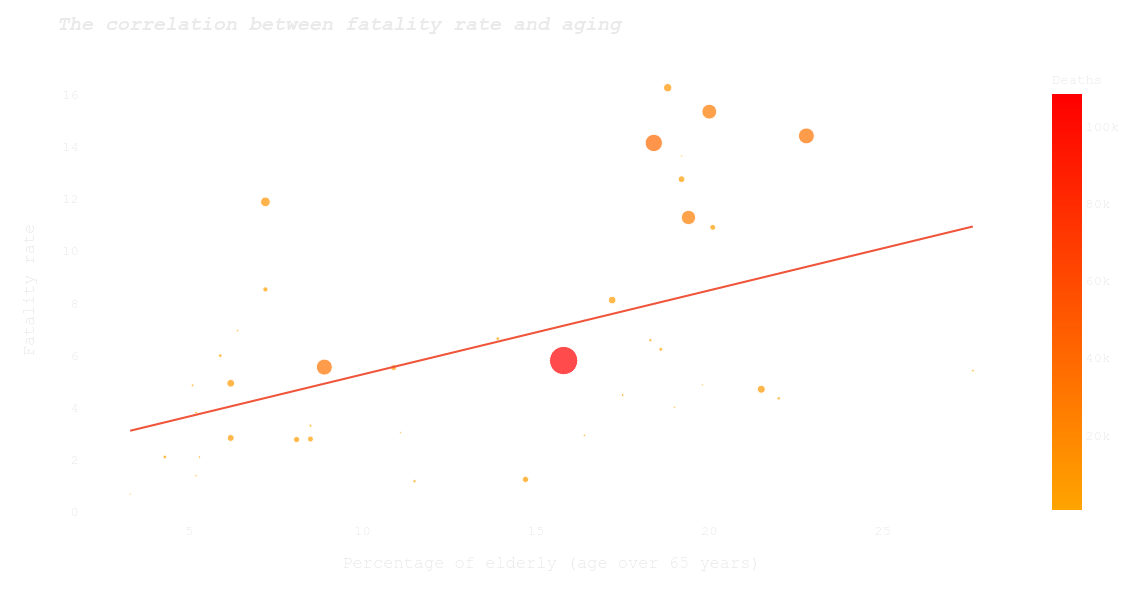

In [80]:
fig = px.scatter(data_frame=age_fatality_correlation_df, x='over 65 years', y='Fatality rate',
                 color='Deaths',
                 size='Deaths', hover_data=['Country', 'Confirmed'],
                 color_continuous_scale=['orange', 'red'],
                 trendline='ols')

fig.update_layout(autosize=False,
                  width=1000, height=600,
                  title_text='<i><b>The correlation between fatality rate and aging</b></i>',
                  xaxis_title="Percentage of elderly (age over 65 years)",
                  yaxis_title="Fatality rate",
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor= 'rgba(0, 0, 0, 0)',
                  font={
                      'family': "Courier New, monospace",
                      'size': 14,
                      'color': "#eaeaea"
                  }
                 )

fig.show()

In [81]:
save_fig_as_div(fig_obj=fig, file_name='age_vs_fatality_rate_scatter_plot.html')